<a href="https://colab.research.google.com/github/manvendra7/END2.0-Assignment3-Pytorch101/blob/main/Assignment_3_Pytorch_Approach1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms
torch.cuda.is_available()


True

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import random
def Rand(start, end, num):
    res = []
    for j in range(num):
        res.append(random.randint(start, end)) 
    return res

In [ ]:
# let's extend the Dataset class of Pytorch to build our own sample dataset
from torch.utils.data import Dataset
class rand_num(torch.utils.data.Dataset):
  def __init__(self):
    self.data = Rand(0, 9, 60000)

  def __getitem__(self, index):
    r = self.data[index]
    return r
  
  def __len__(self):
    return len(self.data)

In [ ]:
df1 = rand_num()

In [ ]:
train_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class ImageDataset(Dataset):
    """Tabular and Image dataset."""

    def __init__(self, images, num, labels=None, transforms=None):
        self.X = images
        self.X2 = num

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        data = self.X[i][0]
        data2 = self.X2[i]
        Y = self.X[i][1]
        Y2 = self.X2[i] + self.X[i][1]

        return data,data2,Y, Y2

In [ ]:
data_combined = ImageDataset(train_set,df1)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        dropout_value = 0.1

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=30, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(30),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=20, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.dropout = nn.Dropout(dropout_value)
        
        # IN: 30 (20 mnist + 10 OHE rand num)
        self.prefinal_layer1 = nn.Sequential(
            nn.Linear(in_features=30, out_features=60, bias=False),
            nn.BatchNorm1d(60),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.prefinal_layer2 = nn.Sequential(
            nn.Linear(in_features=60, out_features=60, bias=False),
            nn.BatchNorm1d(60),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # IN: 60 ; OUT: 10
        self.mnist_final_layer = nn.Sequential(
            nn.Linear(in_features=60, out_features=10, bias=False),
        )

        # IN: 60 ; OUT 19
        self.adder_final_layer = nn.Sequential(
            nn.Linear(in_features=60, out_features=19, bias=False)
        )
    
    def forward(self, img, rand_no):
        rand_num = F.one_hot(rand_no, num_classes=10)

        img = self.convblock1(img)
        img = self.convblock2(img)
        img = self.convblock3(img)
        img = self.pool1(img)
        img = self.convblock4(img)
        img = self.convblock5(img)
        img = self.convblock6(img)
        img = self.gap(img)        
        img = self.convblock8(img)

        img = img.view(-1, 20)
        
        ccat = torch.cat([img, rand_num], dim=-1)

        pre_out = self.prefinal_layer1(ccat)
        pre_out = self.prefinal_layer2(pre_out)

        mnist_out = self.mnist_final_layer(pre_out)
        adder_out = self.adder_final_layer(pre_out)


        return mnist_out, adder_out

       

In [ ]:
import torch.optim as optim
network = Network().to(device)


In [ ]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
train_loader = torch.utils.data.DataLoader(data_combined, batch_size=64)
optimizer = optim.Adam(network.parameters(), lr=0.16)
train_errors = []
train_acc = []
loss_history = []
acc_history = []
n_train = len(train_loader)*64
for epoch in range(20):
    network.train()
    total_loss = 0
    total_correct = 0
    total_correct1 = 0
    total_correct2 = 0
    
    running_loss1 = 0
    running_loss2 = 0
    
    c = 0
    for batch in train_loader: # Get Batch

        c = c + 1
        images, labels, ran_no, add = batch 
        images, labels, ran_no, add = images.to(device), labels.to(device),ran_no.to(device), add.to(device)

        
        preds1, preds2 = network(images, ran_no) # Pass Batch
        #preds1 = torch.tensor(preds1,dtype=torch.long)
        loss1 = F.cross_entropy(preds1, labels) # Calculate Loss

        loss2 = F.cross_entropy(preds2, add) # Calculate Loss

        loss = loss1 + loss2
        #loss.requres_grad = True
        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

       

        total_loss += loss.item()
        #total_correct1 += torch.sum(torch.max(preds1, dim = 1)[1] == labels).item()*1.0
        #total_correct2 += torch.sum(torch.max(preds2, dim = 1)[1] == add).item()*1.0
        #total_correct += total_correct1 + total_correct2 

        #running_loss1 += loss1.item()
        #running_loss2 += loss2.item()

    print("Epoch: {} Train_Loss: {}".format(epoch+1,total_loss/n_train))
    train_errors.append(total_loss/n_train)
    #train_acc.append(total_correct1/n_train)
   

Epoch: 1 Train_Loss: 0.0760106166034365
Epoch: 2 Train_Loss: 0.07621545582882631
Epoch: 3 Train_Loss: 0.07591661084085893
Epoch: 4 Train_Loss: 0.07601234472509641
Epoch: 5 Train_Loss: 0.0763436169909643
Epoch: 6 Train_Loss: 0.07618946790186835
Epoch: 7 Train_Loss: 0.07599144822943693
Epoch: 8 Train_Loss: 0.0767968155697846
Epoch: 9 Train_Loss: 0.07615540529301426
Epoch: 10 Train_Loss: 0.07625830731888823
Epoch: 11 Train_Loss: 0.07605797358190836
Epoch: 12 Train_Loss: 0.07828405800499896
Epoch: 13 Train_Loss: 0.07913985221720199
Epoch: 14 Train_Loss: 0.07914475993370451
Epoch: 15 Train_Loss: 0.07911861251825208
Epoch: 16 Train_Loss: 0.07919594259467969
Epoch: 17 Train_Loss: 0.07931895870199082
Epoch: 18 Train_Loss: 0.07915755822015469
Epoch: 19 Train_Loss: 0.07931185714693974
Epoch: 20 Train_Loss: 0.07915501673020787


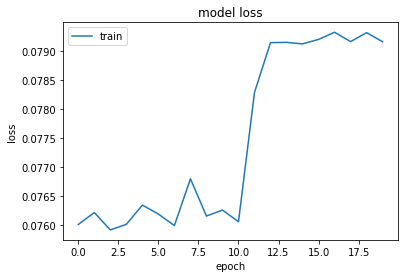

In [ ]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(train_errors)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


In [ ]:
print(network)

Network(
  (convblock1): Sequential(
    (0): Conv2d(1, 14, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(14, 30, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(30, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock4): Sequential(
    (0): Conv2d(10, 14, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock5): Sequential(
    (0): Conv2d(14, 15, kernel_siz